# 2024衆議院選挙における世論地図のデータ

In [46]:
# Import necessary libraries
%pip install --upgrade pip jupyter
%pip install umap-learn pandas matplotlib scikit-learn matplotlib_fontja hdbscan seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import ConvexHull
import json
import matplotlib_fontja
import umap

matplotlib_fontja.japanize()

Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
zid_to_topic = {
    26: "政治資金規制改革",
    28: "税制",
    29: "社会保障（年金・医療）",
    30: "経済政策・物価高対策",
    31: "エネルギー政策",
    34: "憲法",
    38: "デジタル民主主義"
}
topic_to_zid = {
    "政治資金規制改革": 26,
    "税制": 28,
    "社会保障（年金・医療）": 29,
    "経済政策・物価高対策": 30,
    "エネルギー政策": 31,
    "憲法": 34,
    "デジタル民主主義": 38
}

In [54]:
df = pd.read_csv("votes.csv")
matrix = df.pivot_table(index="pid", columns=["zid", "tid"], values="vote")
matrix

zid    26                                      28       ...   38            \
tid    0    1    2    3    4    5    6    7    0    1   ...   10   11   12   
pid                                                     ...                  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     1.0  1.0  1.0  1.0 -1.0 -1.0  1.0 -1.0  1.0  1.0  ... -1.0  1.0 -1.0   
2     0.0 -1.0 -1.0 -1.0  1.0  1.0 -1.0 -1.0  0.0  0.0  ...  1.0 -1.0 -1.0   
3     1.0  0.0  0.0 -1.0  1.0  1.0 -1.0 -1.0  1.0  1.0  ...  1.0  1.0 -1.0   
4     1.0 -1.0 -1.0 -1.0  1.0  1.0  0.0 -1.0  0.0 -1.0  ... -1.0 -1.0 -1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4398  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4399  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4400  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4401  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4402  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

zid                                      
tid    13   14   15   16   17   18   19  
pid                                      
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1    -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
2    -1.0 -1.0 -1.0  1.0  1.0 -1.0 -1.0  
3    -1.0 -1.0 -1.0 -1.0  1.0 -1.0 -1.0  
4    -1.0 -1.0  0.0  1.0 -1.0 -1.0  1.0  
...   ...  ...  ...  ...  ...  ...  ...  
4398  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4399  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4400  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4401  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4402  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[4403 rows x 84 columns]

In [7]:
comment_df = pd.read_csv("comments.csv")[["tid", "zid", "txt"]]
comment_df


,tid,zid,txt
0,0,38,行政手続きをすべてオンライン化する
1,0,26,政治資金パーティーはオンライン含めて開催を禁止する
2,1,26,企業・団体によるパーティー券購入は禁止する
3,2,26,企業・団体献金は禁止する
4,3,26,政策活動費は即時廃止する
...,...,...,...
79,15,38,マイナンバーによる行政のデータ連携を加速し全銀行口座との紐づけを実現することで、所得のリアル...
80,16,38,警察によるウェアラブルカメラの運用を広げ、治安維持対応を強化する
81,17,38,行政手続きにAIを導入し、補助金申請の審査業務などは人間からAIに代替させていく
82,18,38,年末調整は廃止し、国民全員がワンストップで確定申告が可能な行政インフラを整える


In [38]:
readable = {}
comment_df = pd.read_csv("comments.csv")
for i, row in comment_df[['zid', 'tid', 'txt']].iterrows():
    readable[row['zid'], row['tid']] = row['txt']

In [35]:
matrix_keizai = matrix[topic_to_zid["経済政策・物価高対策"]]
matrix_keizai

tid,0,1,2,3,4,5,6
pid,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
2,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0
3,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
4,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0
...,...,...,...,...,...,...,...
4398,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
4399,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0
4400,0.0,-1.0,0.0,1.0,0.0,-1.0,1.0


In [10]:
non_na_counts = matrix_keizai.count(axis=1)  # 欠損していない値の数
from collections import Counter
Counter(non_na_counts)

Counter({7: 3525, 1: 598, 2: 119, 3: 61, 4: 43, 5: 32, 6: 25})

In [39]:
matrix_keizai = matrix_keizai.dropna(thresh=7)
matrix_keizai.shape

(3525, 7)

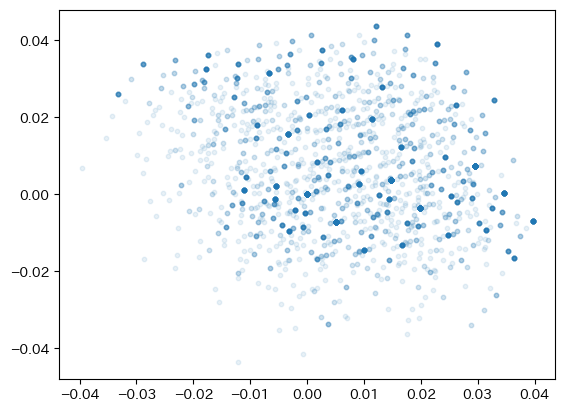

In [51]:
pca = PCA()
pca = pca.fit(matrix_keizai.T)
coords = pca.components_.T

plt.scatter(x=coords[:, 0], y=coords[:, 1], s=10, alpha=0.1)
plt.show()

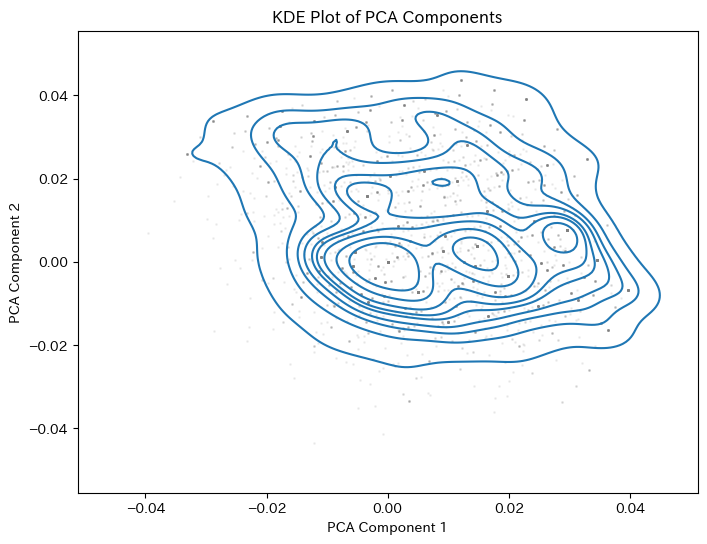

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# KDEプロット
plt.figure(figsize=(8, 6))
sns.kdeplot(x=coords[:, 0], y=coords[:, 1])
plt.scatter(x=coords[:, 0], y=coords[:, 1], s=1, color="gray", alpha=0.1)  # 元の散布図をオーバーレイ
plt.title("KDE Plot of PCA Components")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [43]:
import umap

# UMAPによる次元削減
reducer = umap.UMAP(
    n_neighbors=15, min_dist=1, n_components=2, random_state=42, n_jobs=1
)
embedding = reducer.fit_transform(matrix_keizai)

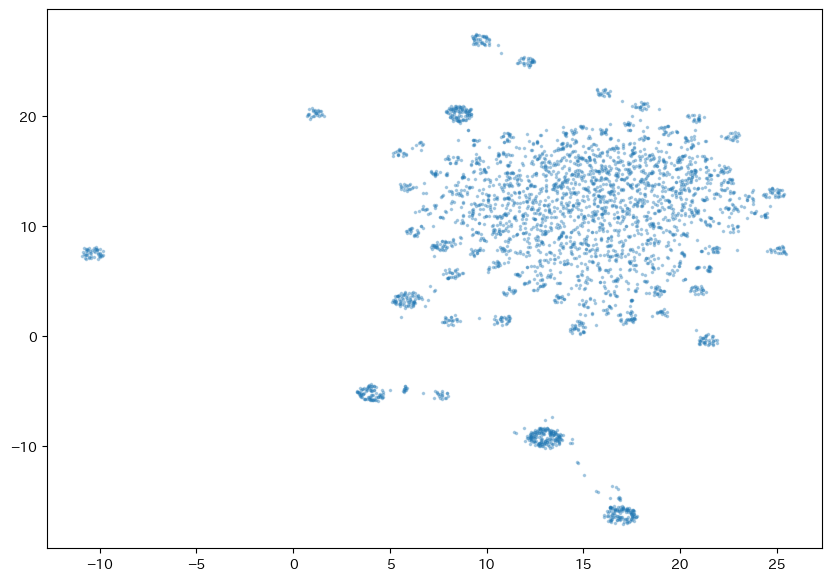

In [44]:
umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])

plt.figure(figsize=(10, 7))
plt.scatter(
    umap_df["UMAP1"],
    umap_df["UMAP2"],
    marker=".",
    alpha=0.3,
    s=10,
)
plt.show()

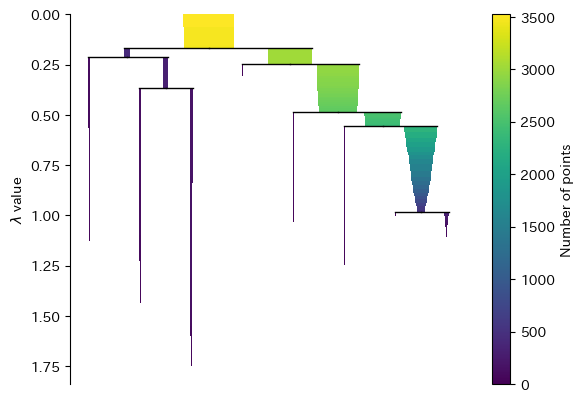

In [65]:
import hdbscan
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=50)
hdbscan_cluster.fit_predict(umap_df)
hdbscan_cluster.condensed_tree_.plot()
labels = hdbscan_cluster.labels_

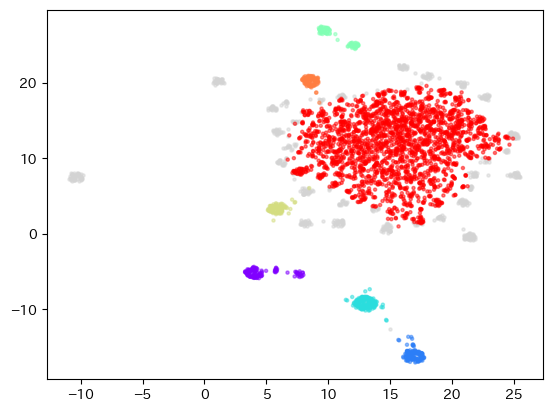

In [66]:
# クラスタラベルが-1（ノイズ）のデータとクラスタのデータを分ける
core_points = umap_df[labels != -1]
core_labels = labels[labels != -1]
noise_points = umap_df[labels == -1]

# ノイズデータを薄い灰色でプロット
plt.scatter(noise_points["UMAP1"], noise_points["UMAP2"], c="lightgray", s=5, marker="o", alpha=0.5, label="Noise")

# クラスタデータをカラーマップでプロット
scatter = plt.scatter(core_points["UMAP1"], core_points["UMAP2"], c=core_labels, s=5, marker="o", alpha=0.5, cmap="rainbow")
plt.show()


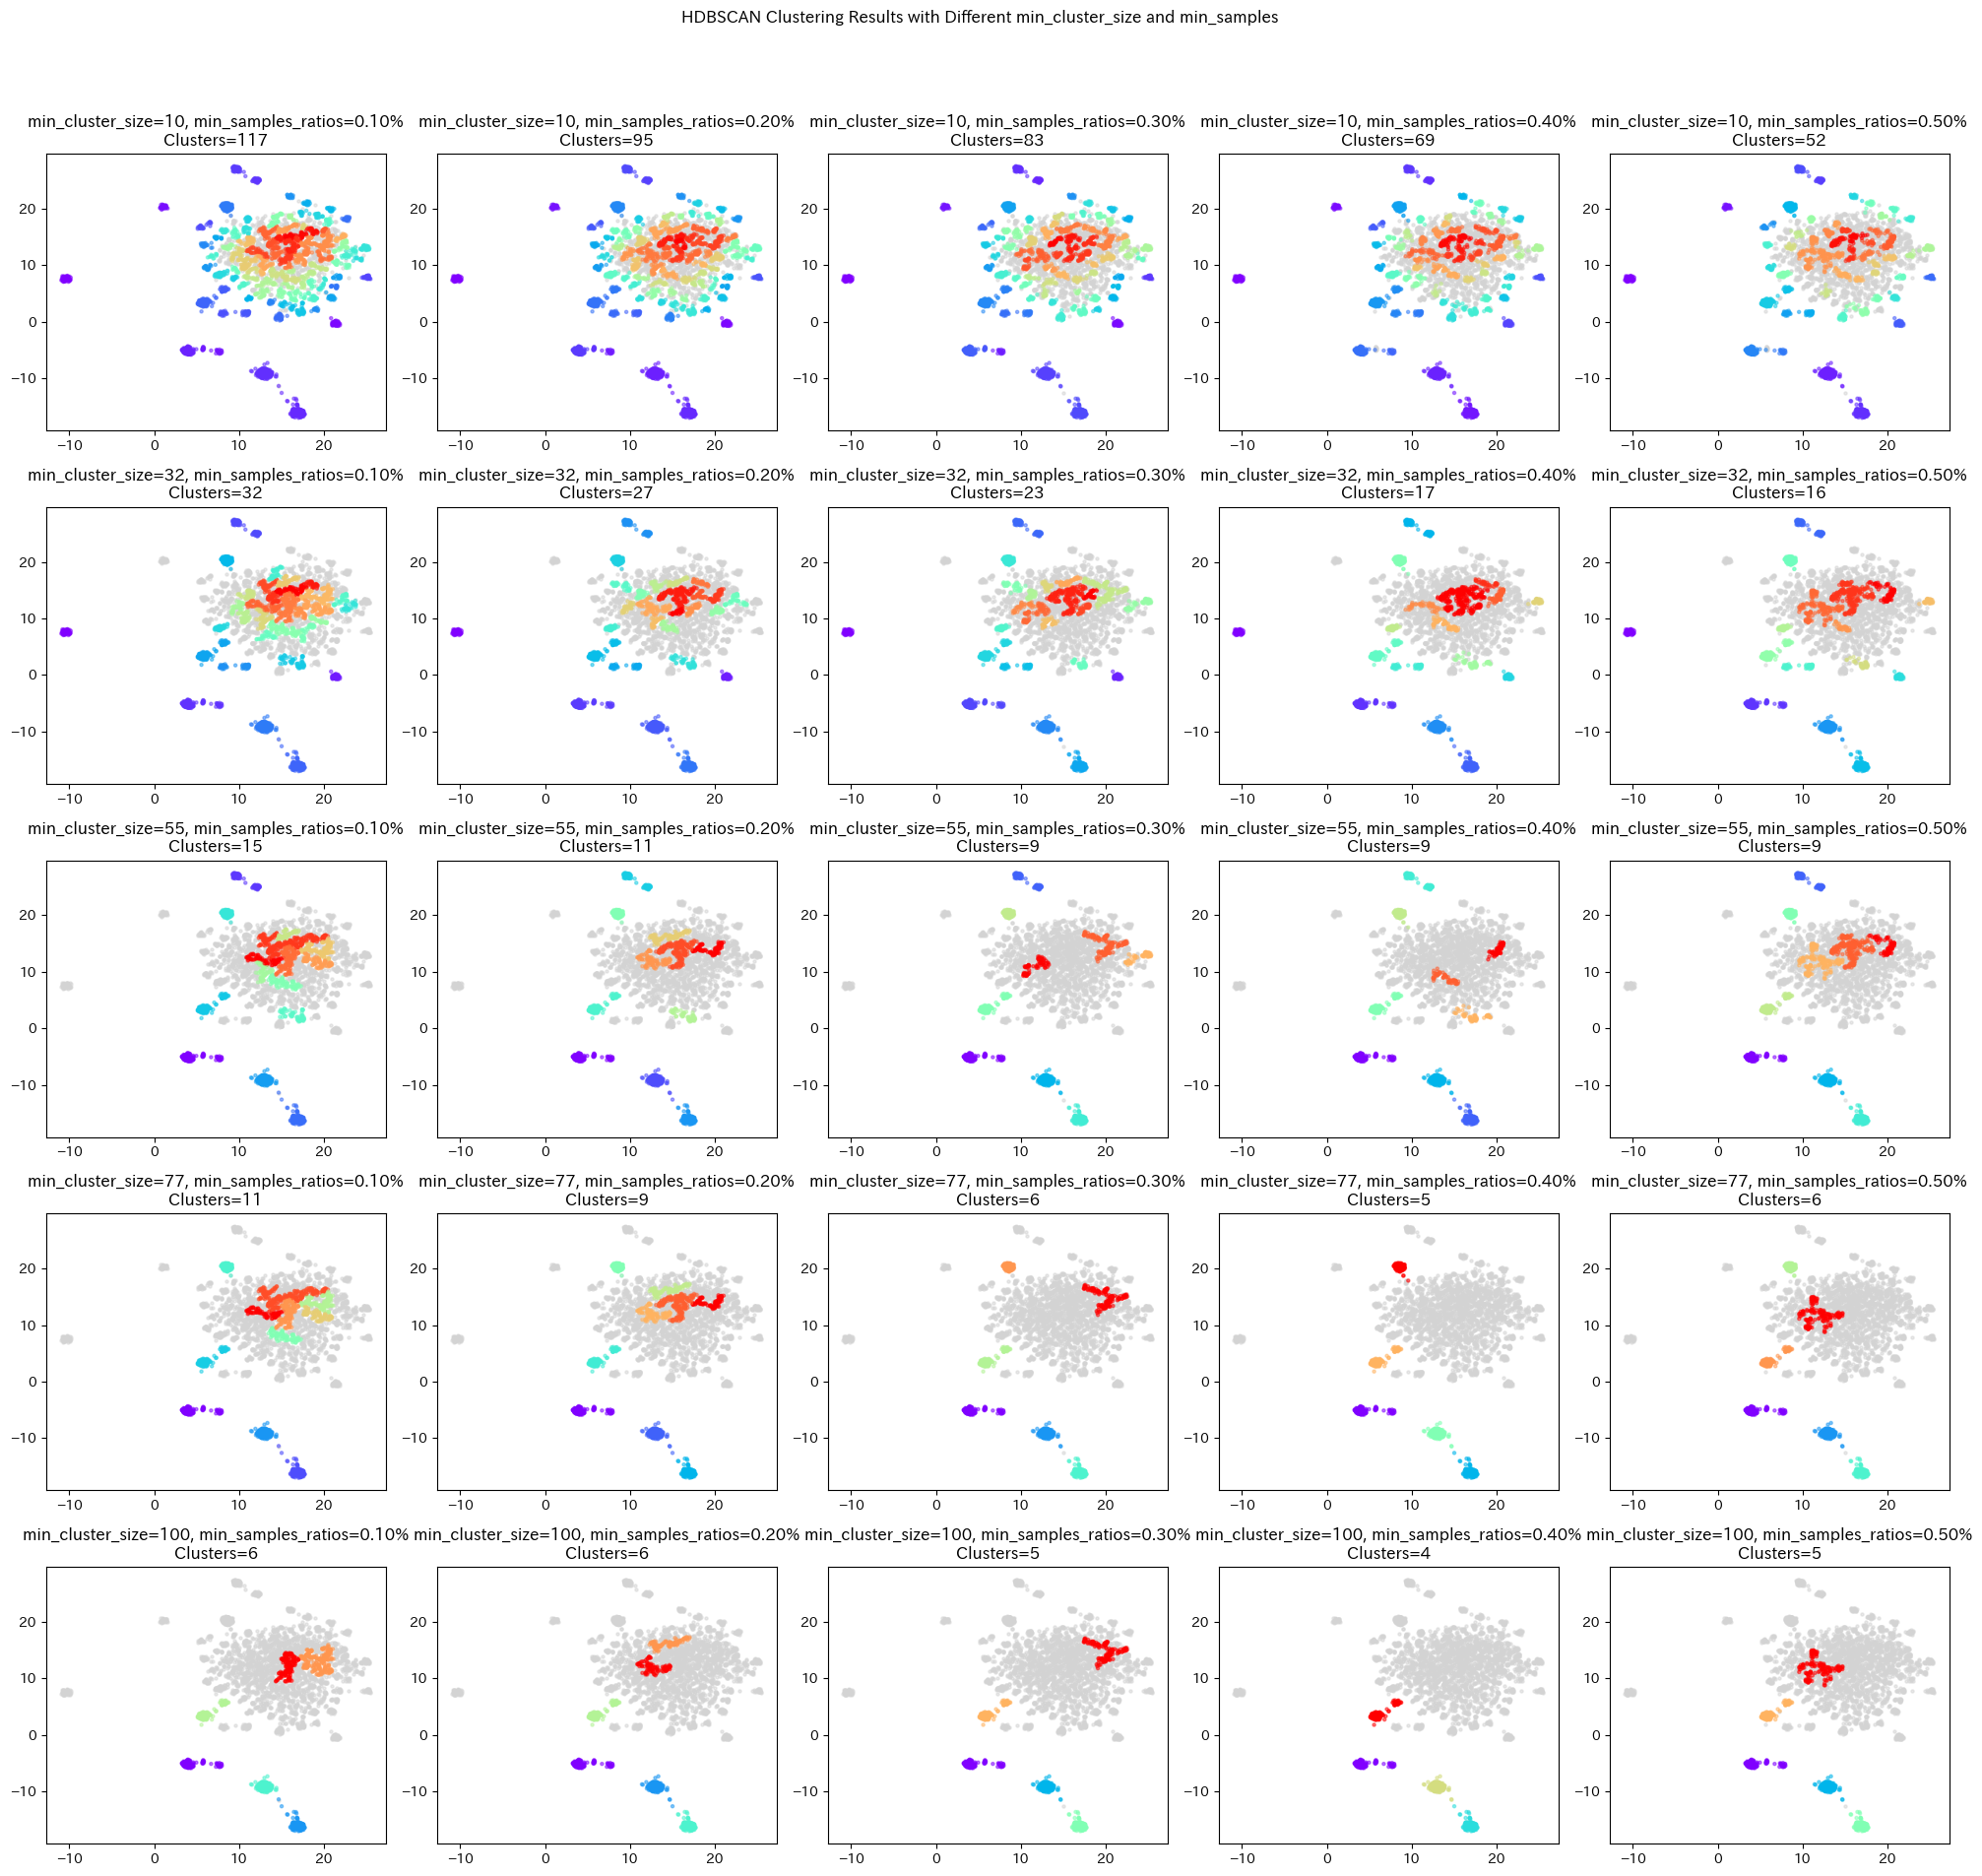

In [32]:


# 例として使うmin_cluster_sizeとmin_samplesのパラメータリストを定義
min_cluster_sizes = np.linspace(10, 100, 5, dtype=int)  # クラスタの最小サイズ
min_samples_ratios = np.linspace(0.001, 0.005, 5)       # データの割合でmin_samplesを決定

# プロット数の決定
n_rows = len(min_cluster_sizes)
n_cols = len(min_samples_ratios)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * len(min_samples_ratios), 4 * len(min_cluster_sizes)))
fig.suptitle("HDBSCAN Clustering Results with Different min_cluster_size and min_samples")

tmp_df = matrix_keizai
# タイリング表示
for i, min_cluster_size in enumerate(min_cluster_sizes):
    for j, ratio in enumerate(min_samples_ratios):
        min_samples = int(len(tmp_df) * ratio)
        
        # HDBSCANのインスタンスを生成
        hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = hdbscan_cluster.fit_predict(umap_df)
        
        # クラスタ数を取得（ノイズ点は除外するためsetから-1を除く）
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # サブプロットにプロット
        ax = axes[i, j]
        # クラスタラベルが-1（ノイズ）のデータとクラスタのデータを分ける
        core_points = umap_df[labels != -1]
        core_labels = labels[labels != -1]
        noise_points = umap_df[labels == -1]

        # ノイズデータを薄い灰色でプロット
        ax.scatter(noise_points["UMAP1"], noise_points["UMAP2"], c="lightgray", s=5, marker="o", alpha=0.5, label="Noise")

        # クラスタデータをカラーマップでプロット
        scatter = ax.scatter(core_points["UMAP1"], core_points["UMAP2"], c=core_labels, s=5, marker="o", alpha=0.5, cmap="rainbow")

        ax.set_title(f"min_cluster_size={min_cluster_size}, min_samples_ratios={ratio * 100:.2f}%\nClusters={n_clusters}")

# タイリングをきれいに配置
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()